In [2]:
import json
import pandas as pd

def read_json_file(file_path):
    with open(file_path, "r") as f:
        return [json.loads(line) for line in f]

def extract_kernel_values(kernel):
    values = {}
    for i, k in enumerate(kernel):
        values[f'm{i}'] = k.get('m', None)
        values[f's{i}'] = k.get('s', None)
        values[f'h{i}'] = k.get('h', None)
    return values

# Carica i dati
masstestClassifier = pd.DataFrame(read_json_file("/Users/alessandrococcia/Desktop/Lenia Tesi/src/masstestClassifier.json"))
results1 = pd.DataFrame(read_json_file("/Users/alessandrococcia/Desktop/Lenia Tesi/src/results1.json"))
results2 = pd.DataFrame(read_json_file("/Users/alessandrococcia/Desktop/Lenia Tesi/src/results2.json"))
results3 = pd.DataFrame(read_json_file("/Users/alessandrococcia/Desktop/Lenia Tesi/src/results3.json"))
data_csv = pd.read_csv("/Users/alessandrococcia/Desktop/Lenia Tesi/src/data.csv")

# Estrai i valori di massa finale e gli input m, s, h dai kernels
def process_dataframe(df):
    kernels = df['kernels']
    kernel_values = kernels.apply(extract_kernel_values)
    kernel_values_df = pd.DataFrame(kernel_values.tolist())
    return pd.concat([df[['mass']], kernel_values_df], axis=1)


In [3]:
dataset = process_dataframe(masstestClassifier)

data_csv.columns = dataset.columns

In [4]:
# Processa ogni dataframe
masstestClassifier_processed = process_dataframe(masstestClassifier)
results1_processed = process_dataframe(results1)
results2_processed = process_dataframe(results2)
results3_processed = process_dataframe(results3)

# Concatenare tutti i dataframe
final_df = pd.concat([
    masstestClassifier_processed,
    results1_processed,
    results2_processed,
    results3_processed,
    data_csv
], ignore_index=True)

# Visualizza il dataframe finale
print(final_df)

               mass       m0       s0       h0       m1       s1       h1  \
0       12452.34101  0.20244  0.16347  0.90716  0.19943  0.16687  0.04334   
1       17136.53284  0.27005  0.17568  0.51318  0.14507  0.16200  0.26783   
2       13496.90794  0.28203  0.10517  0.96772  0.45769  0.11460  0.02386   
3           0.00000  0.25533  0.13721  0.82027  0.49557  0.13667  0.11236   
4       15392.89682  0.33085  0.13453  0.93786  0.46549  0.13629  0.01641   
...             ...      ...      ...      ...      ...      ...      ...   
549800  16780.97296  0.13046  0.10322  0.66479  0.28888  0.10280  0.00176   
549801      0.00000  0.37734  0.14764  0.80877  0.23422  0.15367  0.15052   
549802   8768.36665  0.27615  0.09260  0.72658  0.21300  0.14067  0.04144   
549803      0.00000  0.25549  0.12319  0.38525  0.24009  0.08631  0.27975   
549804  14849.05294  0.16262  0.11552  0.07884  0.41430  0.15336  0.35436   

             m2       s2       h2  ...      h11      m12      s12      h12 

In [5]:
final_df.drop_duplicates(inplace=True)

In [16]:
import wandb
import numpy as np
from sklearn.neural_network import MLPClassifier
import sys
results4 = final_df

out = ['averageLinearSpeed', 'averageVariance', 'averageMass']
training_parameter_batch = [{"max_iter":100,"out_column": "mass", "alpha": 0.2, "learning_rate_init": 0.001, "tag": "mass", "hidden_layer_sizes":(60, 60, 60, 60),"learning_rate": "adaptive", "threshold": 0},
                            {"max_iter":100,"out_column": "mass", "alpha": 0.2, "learning_rate_init": 0.001, "tag": "mass", "hidden_layer_sizes":(60, 60, 60, 60, 60),"learning_rate": "adaptive", "threshold": 0},
                            {"max_iter":100,"out_column": "mass", "alpha": 0.2, "learning_rate_init": 0.001, "tag": "mass", "hidden_layer_sizes":(60, 60, 60),"learning_rate": "adaptive", "threshold": 0},
                            {"max_iter":100,"out_column": "mass", "alpha": 0.2, "learning_rate_init": 0.001, "tag": "mass", "hidden_layer_sizes":(50, 50, 50, 50),"learning_rate": "adaptive", "threshold": 0}
                            ]
for batch in training_parameter_batch:
    out_column = "mass"
    # Inizializza una run su W&B
    wandb.init(project="Lenia", name=out_column, config={
        "learning_rate": "adaptive",
        "learning_rate_init": batch['learning_rate_init'],
        "alpha": batch['alpha'],
        "hidden_layer_sizes": batch['hidden_layer_sizes'],
        "max_iter": batch['max_iter']}, 
        tags=batch['tag'],
        )
    dataset = results4.sample(frac=1, random_state=42).reset_index(drop=True)
    mean = dataset.mean()[1:]
    std = dataset.std()[1:]

    wandb.log({"mean": mean.to_dict(), "std": std.to_dict()})

    TRAIN_TEST_SPLIT_PERCENTAGE = 0.9
    dataset_training = dataset[:int(len(dataset) * TRAIN_TEST_SPLIT_PERCENTAGE)]
    dataset_test = dataset[int(len(dataset) * TRAIN_TEST_SPLIT_PERCENTAGE):]

    # Separare le caratteristiche (X) e il target (y)
    X = dataset_training.drop(columns=[out_column])  # tutte le colonne tranne out_string
    y = dataset_training[out_column]  # solo la colonna out_string

    # Lo stesso per il set di test
    X_test = dataset_test.drop(columns=[out_column])
    y_test = dataset_test[out_column]

    # Convertire i valori di y e y_test in binari
    y = y.apply(lambda x: 1 if x > batch["threshold"] else 0)
    y_test = y_test.apply(lambda x: 1 if x > batch["threshold"] else 0)

    "normalizzazione"
    X = (X - mean) / std
    X_test = (X_test - mean) / std

    "colonna bias"
    X_test['bias'] = 1
    X['bias'] = 1
    
    classes = np.unique(y)

    # Crea il modello MLPClassifier
    mlp = MLPClassifier(hidden_layer_sizes=batch['hidden_layer_sizes'], max_iter=batch['max_iter'], random_state=42, 
                    learning_rate=batch['learning_rate'], alpha=batch['alpha'], learning_rate_init=batch['learning_rate_init'])

    # Addestra il modello con una barra di progresso e registra su W&B
    for i in range(mlp.max_iter):
        if i == 0:
            mlp.partial_fit(X, y, classes=classes)
        else:
            mlp.partial_fit(X, y)
        training_results = mlp.score(X, y)
        testing_results = mlp.score(X_test, y_test)

        # Registra i dati su W&B
        wandb.log({
            "epoca": i, 
            "training_score": training_results, 
            "testing_score": testing_results, 
            "loss": mlp.loss_, 
            "threshold": batch["threshold"]
        })
        sys.stdout.write(f"\rModel for {out_column} is training: {i}/{mlp.max_iter} | Test score: {testing_results:.4f} | Model score: {training_results:.4f}")
        sys.stdout.flush()

    # Termina la run su W&B
    wandb.finish()


Model for mass is training: 99/100 | Test score: 0.8994 | Model score: 0.9065

epoca,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing_score,▁▄▆▆▆▆▆▇▇▇▇▇▇▇▇████▇████████████████████
threshold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_score,▁▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇████████████████████
epoca,99
loss,0.25602
testing_score,0.89944
threshold,0
training_score,0.90648


Model for mass is training: 99/100 | Test score: 0.8969 | Model score: 0.9059

epoca,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing_score,▁▄▆▆▆▆▆▆▇▇▇▇▇█▇▇████████████████████████
threshold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_score,▁▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████████
epoca,99
loss,0.25142
testing_score,0.8969
threshold,0
training_score,0.90591


Model for mass is training: 99/100 | Test score: 0.8975 | Model score: 0.9037

epoca,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing_score,▁▄▆▆▆▇▇▇▇▇▇▇█▇██████████████████████████
threshold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_score,▁▄▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
epoca,99
loss,0.26305
testing_score,0.89747
threshold,0
training_score,0.90367


Model for mass is training: 99/100 | Test score: 0.8947 | Model score: 0.9012

epoca,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing_score,▁▄▆▇▇▇▇▇▇▇▇▇█▇▇▇▇███████████████████████
threshold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_score,▁▄▆▆▇▇▇▇▇▇▇▇████████████████████████████
epoca,99
loss,0.26082
testing_score,0.8947
threshold,0
training_score,0.90117


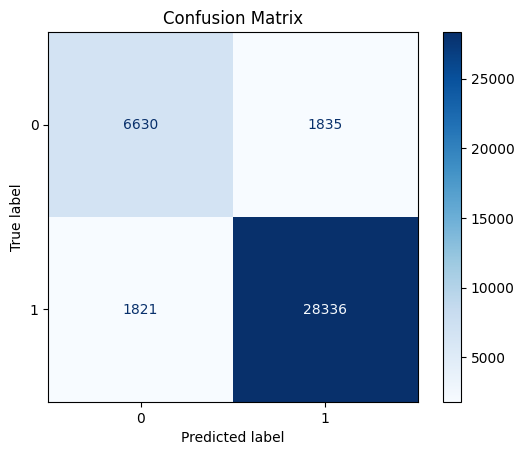

Accuracy: 0.9053
F1 Score: 0.9053
Classe 0: Precisione: 0.7845, Richiamo: 0.7832
Classe 1: Precisione: 0.9392, Richiamo: 0.9396


In [14]:
# Importa le librerie necessarie
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Fai le predizioni sul set di test
y_pred = mlp.predict(X_test)

# Calcola la confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizza la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calcola altre metriche globali
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcola precisione e richiamo per ciascuna classe
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)

# Stampa le metriche globali
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# Stampa precisione e richiamo per ciascuna classe
for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
    print(f'Classe {i}: Precisione: {precision:.4f}, Richiamo: {recall:.4f}')